# DDACS Dataset Tutorial

This tutorial demonstrates how to work with the Deep Drawing and Cutting Simulations (DDACS) Dataset.

## Dataset Logic and Structure

### What is Deep Drawing?
Deep drawing is a manufacturing process where a sheet metal blank is formed into a hollow shape using a die and punch. The dataset captures the complete physics of this process including:

- **Material deformation**: How the metal sheet changes shape
- **Tool interaction**: Forces between forming tools and workpiece  
- **Process parameters**: Variables that control the outcome

### Data Hierarchy
```
Dataset
├── Simulations (32,071 total)
│   ├── Process Parameters (FC, MAT, STHK, BF, GEO, RAD)
│   └── Simulation Results (H5 files)
│       ├── OP10 (Forming Process)
│       │   ├── Components (blank, die, punch, binder)
│       │   └── Timesteps (0: initial → 2: max forming → 3: springback)
│       └── OP20 (Cutting Process)
            ├── Component (blank)
            └── Timesteps (0: initial → 1: springback)
```

### Physical Process Understanding
1. **Initial State (t=0)**: Flat sheet metal blank positioned above die
2. **Forming Process (t=1-2)**: Punch descends, blank deforms into die cavity
3. **Springback (t=3)**: Tools removed, material partially recovers due to elasticity
4. **Final Analysis (OP20)**: Additional springback effects during cutting operations

### Key Components
- **Blank**: The workpiece being formed (most important for analysis)
- **Die**: Lower tool that provides the cavity shape
- **Punch**: Upper tool that pushes material into die
- **Binder**: Holds blank edges to control material flow

### Process Parameters
- **FC**: Friction coefficient [0.05-0.15] - affects material flow
- **MAT**: Material scaling factor [0.9-1.1] - represents different steel grades  
- **STHK**: Sheet thickness [0.95-1.0 mm] - influences formability
- **BF**: Blank holder force [100k-500k N] - controls wrinkling vs tearing
- **GEO**: Geometry type (R/V/X) - shape complexity
- **RAD**: Characteristic radius [30-150 mm] - corner sharpness

## 1. Installation

```bash
pip install "git+https://github.com/BaumSebastian/Deep-Drawing-and-Cutting-Simulations-Dataset.git[examples]"
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from pathlib import Path
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib import ticker

from ddacs import DDACSDataset
from ddacs.utils import extract_point_cloud, extract_mesh, display_structure, extract_element_thickness, extract_point_springback

In [2]:
data_dir = Path("./../data")

dataset = DDACSDataset(data_dir, "h5")
print(f"Loaded {len(dataset)} simulations")

# Display sample simulation
sim_id, metadata, h5_path = dataset[0]
print(f"Sample simulation: {sim_id}")
print(f"File: {h5_path}")
print(f"Metadata: {metadata}")

Loaded 1 simulations
Sample simulation: 16039
File: ..\data\h5\16039.h5
Metadata: [1.0e+00 0.0e+00 0.0e+00 3.0e+01 9.0e-01 5.0e-02 9.5e-01 1.0e+05]


## 2. Understanding the Metadata

The metadata contains the process and geometry parameters that define each simulation.

In [3]:
# Load and analyze metadata
df = dataset._metadata
print(f"Metadata structure:")
print(f"  Total simulations: {len(df)}")
print(f"  Columns: {list(df.columns)}")
print("  > Note: The column 'ID' is not returned in dataset.")

# Show parameter meanings and ranges
print(f"\nParameters (physical values):")

desc = dataset.get_metadata_descriptions()
for key in desc:
    print(f"  > {key:4} - {desc[key]}")

print(f"\nSample metadata values:")
print(df.head())

Metadata structure:
  Total simulations: 1
  Columns: ['ID', 'GEO_R', 'GEO_V', 'GEO_X', 'RAD', 'MAT', 'FC', 'SHTK', 'BF']
  > Note: The column 'ID' is not returned in dataset.

Parameters (physical values):
  > GEO_R - Rectangular geometry (1=yes, 0=no)
  > GEO_V - Concave geometry (1=yes, 0=no)
  > GEO_X - Convex geometry (1=yes, 0=no)
  > RAD  - Characteristic radius [30-150 mm]
  > MAT  - Material scaling factor [0.9-1.1]
  > FC   - Friction coefficient [0.05-0.15]
  > SHTK - Sheet thickness [0.95-1.0 mm]
  > BF   - Blank holder force [100,000-500,000 N]

Sample metadata values:
      ID  GEO_R  GEO_V  GEO_X  RAD  MAT    FC  SHTK        BF
0  16039      1      0      0   30  0.9  0.05  0.95  100000.0


## 3. Understanding the Simulation Data Structure

### HDF5 File Organization
Each simulation is stored as an HDF5 file containing:

```
simulation.h5
├── OP10/ (Forming process)
│   ├── blank/     (11k nodes, 4 timesteps) - The workpiece
│   ├── die/       (1k nodes, 3 timesteps)  - Lower tool
│   ├── punch/     (500 nodes, 3 timesteps) - Upper tool  
│   └── binder/    (100 nodes, 3 timesteps) - Edge clamp
└── OP20/ (Cutting process)
    └── blank/     (11k nodes, 2 timesteps) - Post-forming behavior
```

To display all information use `display_structure(h5_path)` (see end of cell).

### Critical Timestep Understanding OP10
- **Tools have 3 timesteps** (0, 1, 2): They are removed after the deep drawing forming process.
- **Blank has 4 timesteps** (0, 1, 2, 3): Includes springback of forming process after tool removal.
- **Timestep 3**: Maximum forming depth (tools fully engaged)
- **Timestep 4**: Springback state (tools removed, blank partially recovers)

**Important**: Using `timestep=-1` gives different results for tools vs blank due to different timestep counts.

### Critical Timestep Understanding OP20
Operation 20 (`OP20`) depends in operation 10 and describes the cutting of the component after forming. In `OP20` **only** the `blank` component exists **Blank has 2 timesteps** (0, 1): Includes the cut `blank` component before and after springback.

In [4]:
# Explore the HDF5 simulation structure
with h5py.File(h5_path, 'r') as f:
    print("Operations:", list(f.keys()))

    print("\n ----------------------- \n")

    # OP10: Forming operation
    print("OP10 - Forming Process:")
    op10 = f['OP10']
    print("  Components:", list(op10.keys()))

    # Analyze each component
    print("\nComponent Details:")
    for component in ['blank', 'die', 'binder', 'punch']:
        if component in op10:
            comp = op10[component]
            nodes = comp['node_displacement'].shape[0]

            if 'node_displacement' in comp:
                disp_shape = comp['node_displacement'].shape
                timesteps = disp_shape[0] if len(disp_shape) == 3 else 1
                print(f"  {component}: {nodes} nodes, {timesteps} timesteps")
            else:
                print(f"  {component}: {nodes} nodes, no displacement")

    print("\n ----------------------- \n")

    # OP20: Springback operation
    print("OP20 - Cutting Process:")
    op20 = f['OP20']
    print("  Components:", list(op20.keys()))

    # Analyze each component
    print("\nComponent Details:")
    for component in ['blank']:
        if component in op20:
            comp = op20[component]
            nodes = comp['node_displacement'].shape[0]

            if 'node_displacement' in comp:
                disp_shape = comp['node_displacement'].shape
                timesteps = disp_shape[0] if len(disp_shape) == 3 else 1
                print(f"  {component}: {nodes} nodes, {timesteps} timesteps")
            else:
                print(f"  {component}: {nodes} nodes, no displacement")

# For whole content use display_structure
# display_structure(h5_path)

Operations: ['OP10', 'OP20']

 ----------------------- 

OP10 - Forming Process:
  Components: ['binder', 'blank', 'die', 'general', 'punch']

Component Details:
  blank: 4 nodes, 4 timesteps
  die: 3 nodes, 3 timesteps
  binder: 3 nodes, 3 timesteps
  punch: 3 nodes, 3 timesteps

 ----------------------- 

OP20 - Cutting Process:
  Components: ['blank']

Component Details:
  blank: 2 nodes, 2 timesteps


## 4. Visualization Examples

The following sections demonstrate different visualization approaches for the simulation data.

In [5]:
try:
    import scienceplots
    plt.style.use(['science'])
except ImportError as exc:
    print("For proper plotting, use scienceplots")

# Standard figure sizes (width, height) in inches based on paper dimensions.
FIGURE_SIZES = {
    'single_col': (3.5, 2.6),      # Single column
    'single_col_cb': (5, 3.5),     # Single column, with colorbar
    'single_col_tall': (3.5, 3.5), # Single column, square-ish
    'double_col': (7.0, 3.0),      # Double column, wide
    'double_col_tall': (7.0, 4.5), # Double column, taller
    'square': (3.5, 3.5),          # Square single column
    'poster': (10, 8),             # For presentations/posters
}

# Visualization constants for consistency
FIGURE_SIZE = FIGURE_SIZES['double_col']
FIGURE_DPI = 150
AXIS_LIMITS = [0, 110]
VIEW_ELEVATION = 30
VIEW_AZIMUTH = 45

# Component settings
COMPONENT_COLORS = {'blank': 'red', 'die': 'blue', 'punch': 'green', 'binder': 'orange'}
COMPONENT_NAMES = {'blank': 'Blank (Workpiece)', 'die': 'Die (Lower Tool)',
                   'punch': 'Punch (Upper Tool)', 'binder': 'Binder (Clamp)'}

### 4.1. Visualize Point Cloud
Point clouds show the spatial distribution of nodes in each component. This visualization is useful for:
  - Understanding the overall geometry and tool positioning
  - Checking data quality and node density
  - Getting a quick overview of the forming setup at any timestep
  - Identifying areas with high/low mesh resolution

Keep in mind, when working with different components, that a `-1` timestep index would result in different component states respectively (see previous cell descriptions). Therefore it is recommended to start from `0`.

blank: 11236 nodes
die: 1218 nodes
punch: 599 nodes
binder: 114 nodes


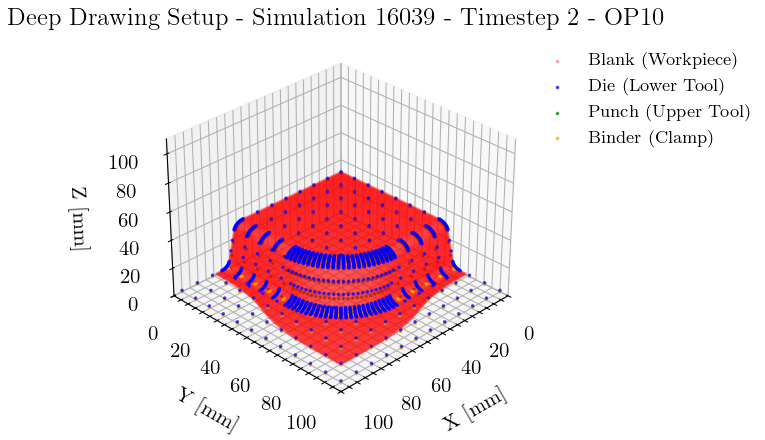

In [6]:
# Variables
FINAL_FORMING_TIMESTEP=2 # The last time step of the forming operation where the tools and blank exist.

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='3d')

for component in COMPONENT_COLORS.keys():
    try:
        # Get point cloud information
        coords = extract_point_cloud(h5_path, component, timestep=FINAL_FORMING_TIMESTEP)
        alpha = 0.3 if component == 'blank' else 0.7
        ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                  c=COMPONENT_COLORS[component], label=COMPONENT_NAMES[component],
                  s=0.5, alpha=alpha)
        print(f"{component}: {coords.shape[0]} nodes")
    except Exception as e:
        print(f"Could not load {component}: {e}")

ax.set_title(f'Deep Drawing Setup - Simulation {sim_id} - Timestep {FINAL_FORMING_TIMESTEP} - OP10')

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

### 4.2. Visualize Mesh
Mesh visualization shows the actual surface geometry with connected elements. Unlike point clouds, meshes reveal:
  - The continuous surface shape of components
  - Element connectivity and mesh quality
  - Realistic representation of tool and workpiece surfaces
  - Better understanding of contact interfaces between components

Every component contains a mesh, which can be displayed using the following code:

Mesh: 11236 vertices, 22050 faces


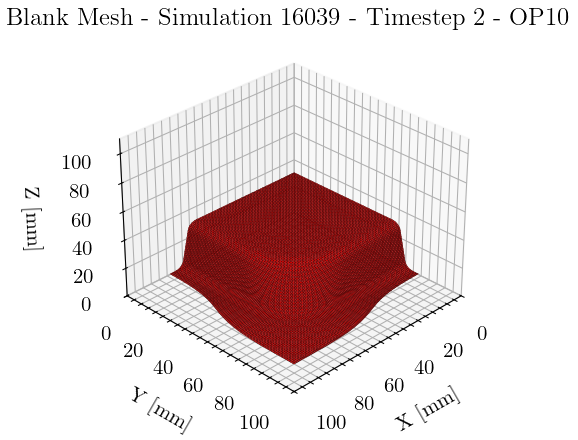

In [7]:
# Variables
FINAL_FORMING_TIMESTEP = 2 # The last time step of the forming operation where the tools and blank exist.
COMPONENT = 'blank' # Can be blank, die, punch or binder.

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='3d')

# Get mesh information
vertices, triangles = extract_mesh(h5_path, COMPONENT, timestep=FINAL_FORMING_TIMESTEP)
faces = vertices[triangles]

mesh = Poly3DCollection(faces,  facecolor=COMPONENT_COLORS[COMPONENT], edgecolor='black', linewidth=0.1)
ax.add_collection3d(mesh)

print(f"Mesh: {vertices.shape[0]} vertices, {triangles.shape[0]} faces")

ax.set_title(f'Blank Mesh - Simulation {sim_id} - Timestep {FINAL_FORMING_TIMESTEP} - OP10')

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.tight_layout()
plt.show()

### 4.3. Visualize Mesh of Operation 20
Operation 20 (`OP20`) represents the cutting/trimming phase after forming. Key differences from `OP10`:
  - **Purpose**: Analyzes springback behavior during cutting operations
  - **Components**: Only the blank exists (tools are removed)
  - **Timesteps**: Fewer timesteps (0: state after cutting and before springback, 1: after springback)
  - **Physics**: Focuses on material recovery when constraints are released

Both previous visualization methods can be executed for OP20, with the limitations, that time steps differ and only `blank` component exist. As only the `blank` component exists, the negative timestep index `-1` does not cause any trouble.

Mesh: 4172 vertices, 7926 faces


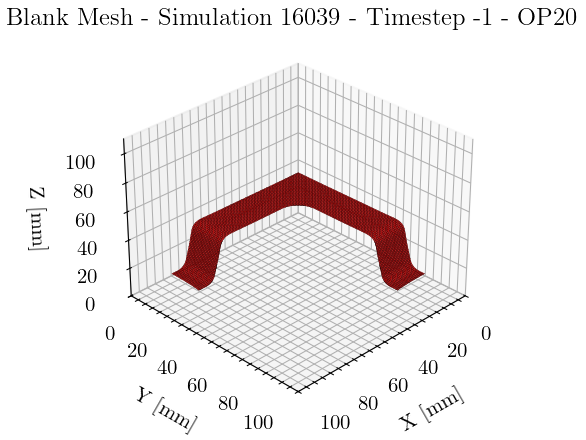

In [8]:
# Variables
CUTTING_TIMESTEP = -1 # The last time step of the cutting operation.
OPERATION = 20 # 20 for cutting operation, 10 for forming.
COMPONENT = 'blank' # Only blank possible, if operation 20 is selected.

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='3d')

# Get mesh information
vertices, triangles = extract_mesh(h5_path, COMPONENT, timestep=CUTTING_TIMESTEP, operation=OPERATION)
faces = vertices[triangles]

mesh = Poly3DCollection(faces, facecolor=COMPONENT_COLORS[COMPONENT], edgecolor='black', linewidth=0.1)
ax.add_collection3d(mesh)

print(f"Mesh: {vertices.shape[0]} vertices, {triangles.shape[0]} faces")

ax.set_title(f'Blank Mesh - Simulation {sim_id} - Timestep {CUTTING_TIMESTEP} - OP{OPERATION}')

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.tight_layout()
plt.show()

## 5. Visualize Physical Features
The following sections demonstrate how to visualize important physical quantities that reveal the manufacturing process physics. Examples are:
  - Material behavior during forming
  - Springback and dimensional accuracy

### 5.1 Thickness Distribution
Material thickness changes during deep drawing due to stretching and compression. The Thickness analysis reveals:
  - **Thinning zones** (Purple): High-stretch areas prone to necking or tearing
  - **Thickening zones** (Yellow): Compression areas, often near binder contact
  - **Critical areas**: Where thickness reduction exceeds material limits
  - **Process optimization**: Identifying parameter adjustments needed

Thickness range: 0.9421 - 1.0696 mm


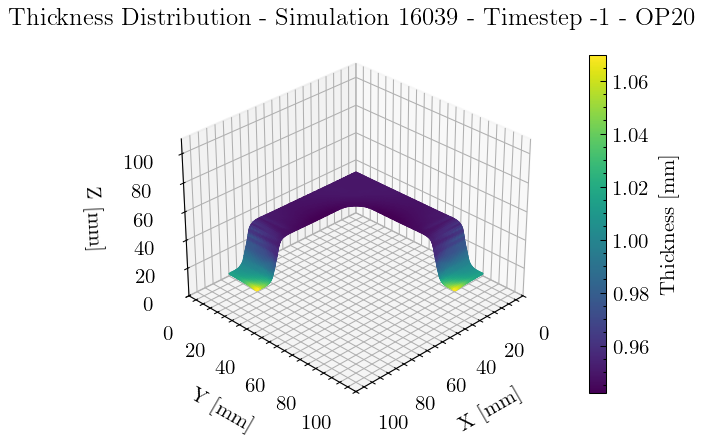

In [ ]:
# Variables
THICKNESS_TIMESTEP = -1 # The last time step of the operation.
COMPONENT = 'blank' # Only blank possible if operation 20 is selected.
OPERATION = 20 # Can be 10 or 20.

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='3d')

# Get mesh and thickness information
vertices, triangles = extract_mesh(h5_path, 'blank', timestep=THICKNESS_TIMESTEP, operation=OPERATION)
thickness = extract_element_thickness(h5_path, timestep=THICKNESS_TIMESTEP, operation=OPERATION)
faces = vertices[triangles]

# Map element data to triangles
thickness_per_triangle = np.repeat(thickness, 2)[:len(triangles)]
print(f"Thickness range: {thickness.min():.4f} - {thickness.max():.4f} mm")
norm_thickness = (thickness_per_triangle - thickness.min()) / (thickness.max() + 0.00001 - thickness.min())

colors = plt.cm.viridis(norm_thickness)
collection = Poly3DCollection(faces, facecolors=colors, edgecolors=colors, alpha=1)

ax.add_collection3d(collection)
ax.plot_surface

sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(thickness.min(), thickness.max()))
cbar = plt.colorbar(sm, ax=ax, shrink=.8)
cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
cbar.set_label('Thickness [mm]')

ax.set_title(f'Thickness Distribution - Simulation {sim_id} - Timestep {THICKNESS_TIMESTEP} - OP{OPERATION}')
ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.tight_layout()
plt.show()


### 5.2 Display Springback
Springback is the elastic recovery of material after tool removal. This phenomenon:
  - **Affects dimensional accuracy** of the final part
  - **Varies by location** depending on stress distribution during forming
  - **Influences tooling design** requiring compensation strategies
  - **Depends on material properties** and process parameters

The visualization interpretation:
  - **Color intensity**: Magnitude of springback displacement
  - **Hot spots** (red/yellow): Areas with significant dimensional changes
  - **Cool areas** (blue/purple): Stable regions with minimal springback
  - **Patterns**: Often concentrated near corners and high-curvature areas

The different visualization techniques are executed on the same simulation & operation. As the springback is always the last timestep and the timestep before the last timestep, the method `extract_point_springback` only requires the operation and simulation.

In [10]:
# Variables
OPERATION = 20 # Can be 10 or 20.

# Get springback information
final_coords, displacement_vectors = extract_point_springback(h5_path, operation=OPERATION)

# Calculate displacement magnitude for color mapping
displacement_magnitude = np.linalg.norm(displacement_vectors, axis=1)

# Statistics
print(f"Springback statistics:")
print(f" - Mean magnitude: {displacement_magnitude.mean():.4f} mm")
print(f" - Max magnitude: {displacement_magnitude.max():.4f} mm")
print(f" - Min magnitude: {displacement_magnitude.min():.4f} mm")
print(f" - Std deviation: {displacement_magnitude.std():.4f} mm")

Springback statistics:
 - Mean magnitude: 0.3887 mm
 - Max magnitude: 1.3650 mm
 - Min magnitude: 0.0000 mm
 - Std deviation: 0.3917 mm


#### 5.2.1 3D Point Cloud with Springback Magnitude
Shows the final geometry as a colored point cloud where colors represent springback magnitude     

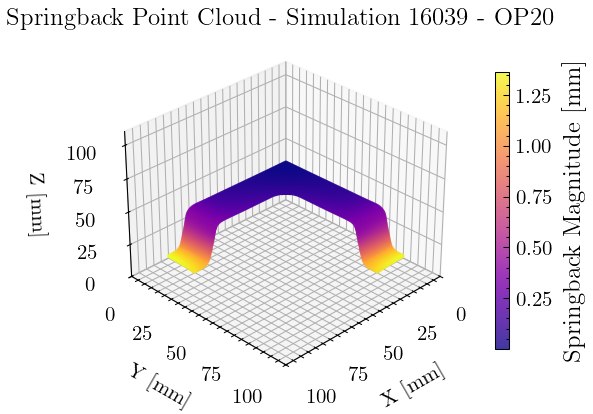

In [11]:
fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(final_coords[:, 0], final_coords[:, 1], final_coords[:, 2],
                    c=displacement_magnitude, cmap='plasma', s=1, alpha=0.8)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Springback Magnitude [mm]', fontsize=12)

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_title(f'Springback Point Cloud - Simulation {sim_id} - OP{OPERATION}')

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

plt.show()

 #### 5.2.2 2D Top View (X-Y Projection)
The 2D projection provides a limited overview of springback patterns by removing the depth dimension. This approach has **limited resolution** as it:
  - **Loses Z-direction information**: Vertical springback components are not clearly visible
  - **Overlaps nodes**: Multiple Z-levels project to the same X-Y position
  - **Reduces spatial understanding**: Difficult to correlate with 3D geometry
  - **Masks complex patterns**: 3D springback vectors appear simplified

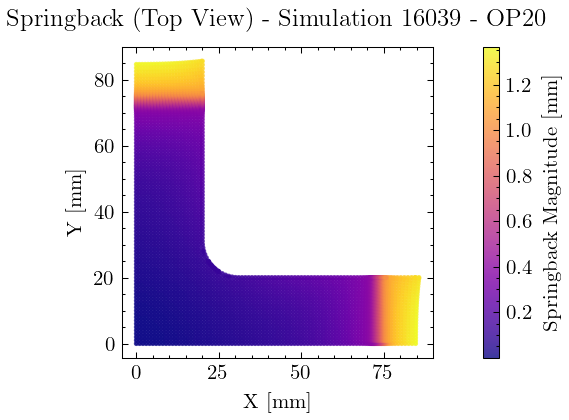

In [12]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)

scatter = ax.scatter(final_coords[:, 0], final_coords[:, 1],
                    c=displacement_magnitude, cmap='plasma', s=2, alpha=0.8)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Springback Magnitude [mm]')

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_title(f'Springback (Top View) - Simulation {sim_id} - OP{OPERATION}', pad=10)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

#### 5.2.3 Springback Vector Field (Quiver Plot)
Vector visualizations show both magnitude and direction of springback displacement:
  - **Arrow direction**: Shows the direction of material movement during springback
  - **Arrow length**: Proportional to displacement magnitude (specified by `SCALING`)
  - **Arrow density**: Controlled by subsampling (every Nth point `STEP`)
  - **Physical insight**: Reveals how material "flows back" after tool removal

**Interpretation tips:**
  - Arrows pointing outward indicate material expansion/recovery
  - Arrows pointing inward suggest local compression effects
  - Clustered arrows show regions of coordinated springback movement
  - Arrow length patterns reveal springback intensity gradients

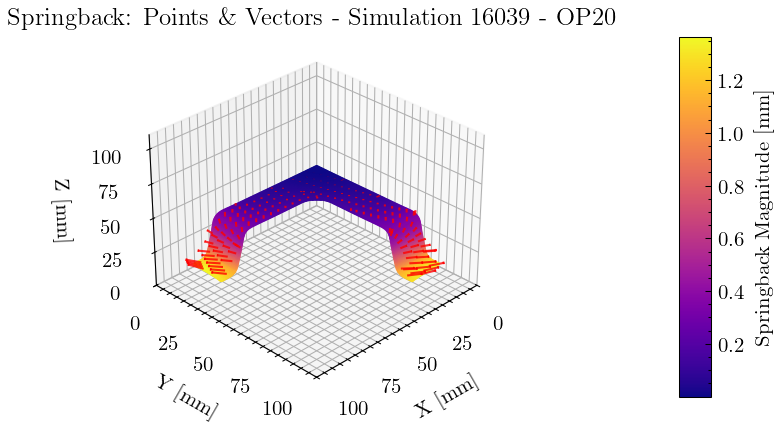

In [13]:
# Variables
STEP = 25 # Resolution/Amount of arrows
SCALING = 10 # Scaling of the arrows

fig = plt.figure(figsize=FIGURE_SIZE, dpi=FIGURE_DPI)
ax = fig.add_axes([0.1, 0.1, 0.6, 0.8], projection='3d')

scatter = ax.scatter(final_coords[:, 0], final_coords[:, 1], final_coords[:, 2],
                    c=displacement_magnitude, cmap='plasma', s=1, alpha=1)

# Vectors (subsampled)
coords_sub = final_coords[::STEP]
vectors_sub = displacement_vectors[::STEP] * SCALING

ax.quiver(coords_sub[:, 0], coords_sub[:, 1], coords_sub[:, 2],
          vectors_sub[:, 0], vectors_sub[:, 1], vectors_sub[:, 2],
          color='red', alpha=0.8, arrow_length_ratio=0.1)

cbar_ax = fig.add_axes([0.75, 0.1, 0.03, 0.8])
cbar = plt.colorbar(scatter, cax=cbar_ax)
cbar.set_label('Springback Magnitude [mm]')

ax.set_xlim(AXIS_LIMITS)
ax.set_ylim(AXIS_LIMITS)
ax.set_zlim(AXIS_LIMITS)
ax.view_init(VIEW_ELEVATION, VIEW_AZIMUTH)

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_title(f'Springback: Points \& Vectors - Simulation {sim_id} - OP{OPERATION}')

plt.show()